# 1. Setup


## 1.1 Install Dependencies


In [12]:
!pip install opencv-python matplotlib kivy --quiet

In [ ]:
!git clone https://github.com/hoangducanh1865/face_recognition

## 1.2 Import Dependencies


In [10]:
# Import standard dependencies
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [13]:
# Import tensorflow dependencies - Functional API
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

TypeError: Couldn't build proto file into descriptor pool: duplicate symbol 'tensorflow.CoordinatedJob'

## 1.3 Set GPU Growth


In [4]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices("GPU")
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

## 1.4 Create Folder Structures


In [5]:
# Setup paths
POS_PATH = os.path.join("data", "positive")
NEG_PATH = os.path.join("data", "negative")
ANC_PATH = os.path.join("data", "anchor")

In [6]:
# Make the directories
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

FileExistsError: [Errno 17] File exists: 'data/positive'

# 2. Collect Positives and Anchors


## 2.1 Untar Labelled Faces in the Wild Dataset


In [ ]:
# http://vis-www.cs.umass.edu/lfw/

In [7]:
# Uncompress Tar GZ Labelled Faces in the Wild Dataset
# !tar -xf lfw.tgz

tar: Error opening archive: Failed to open 'lfw.tgz'


In [7]:
# Move LFW Images to the following repository data/negative
# Updated for Kaggle LFW dataset structure: lfw/lfw-deepfunneled/lfw-deepfunneled/Person_Name/image.jpg
LFW_PATH = os.path.join("lfw", "lfw-deepfunneled", "lfw-deepfunneled")

for directory in os.listdir(LFW_PATH):
    person_dir = os.path.join(LFW_PATH, directory)
    if os.path.isdir(person_dir):
        for file in os.listdir(person_dir):
            EX_PATH = os.path.join(person_dir, file)
            NEW_PATH = os.path.join(NEG_PATH, file)
            os.replace(EX_PATH, NEW_PATH)

## 2.2 Collect Positive and Anchor Classes


In [8]:
# Import uuid library to generate unique image names
import uuid

In [9]:
os.path.join(ANC_PATH, "{}.jpg".format(uuid.uuid1()))

'data/anchor/657d5622-e4c3-11f0-8e04-4ef801895957.jpg'

In [ ]:
# Establish a connection to the webcam
CAMERA_INDEX = 0  # Change to 1 for iPhone/external camera

cap = cv2.VideoCapture(CAMERA_INDEX)
while cap.isOpened():
    ret, frame = cap.read()

    if not ret:
        print("Failed to grab frame")
        break

    # Resize full frame to 250x250 (captures entire image, not just a crop)
    frame_resized = cv2.resize(frame, (250, 250))

    # Collect anchors
    if cv2.waitKey(1) & 0xFF == ord("a"):
        imgname = os.path.join(ANC_PATH, "{}.jpg".format(uuid.uuid1()))
        cv2.imwrite(imgname, frame_resized)
        print(f"Saved anchor: {imgname}")

    # Collect positives
    if cv2.waitKey(1) & 0xFF == ord("p"):
        imgname = os.path.join(POS_PATH, "{}.jpg".format(uuid.uuid1()))
        cv2.imwrite(imgname, frame_resized)
        print(f"Saved positive: {imgname}")

    # Show image back to screen
    cv2.imshow("Image Collection", frame_resized)

    # Breaking gracefully
    if cv2.waitKey(1) & 0xFF == ord("q"):
        break

# Release the webcam
cap.release()
cv2.destroyAllWindows()

Saved anchor: data/anchor/e1115362-e4cb-11f0-8e04-4ef801895957.jpg
Saved anchor: data/anchor/e3b8f5d4-e4cb-11f0-8e04-4ef801895957.jpg
Saved anchor: data/anchor/e942f6da-e4cb-11f0-8e04-4ef801895957.jpg
Saved anchor: data/anchor/ec17fa0e-e4cb-11f0-8e04-4ef801895957.jpg
Saved anchor: data/anchor/f0e323d8-e4cb-11f0-8e04-4ef801895957.jpg
Saved anchor: data/anchor/f6b242bc-e4cb-11f0-8e04-4ef801895957.jpg
Saved anchor: data/anchor/f81703c2-e4cb-11f0-8e04-4ef801895957.jpg
Saved anchor: data/anchor/f9edbed4-e4cb-11f0-8e04-4ef801895957.jpg
Saved anchor: data/anchor/fa6c33d6-e4cb-11f0-8e04-4ef801895957.jpg
Saved anchor: data/anchor/faf22a54-e4cb-11f0-8e04-4ef801895957.jpg
Saved anchor: data/anchor/fb577562-e4cb-11f0-8e04-4ef801895957.jpg
Saved anchor: data/anchor/fc1c77ea-e4cb-11f0-8e04-4ef801895957.jpg
Saved anchor: data/anchor/0042bf6e-e4cc-11f0-8e04-4ef801895957.jpg
Saved anchor: data/anchor/0205c5c6-e4cc-11f0-8e04-4ef801895957.jpg
Saved anchor: data/anchor/03b07448-e4cc-11f0-8e04-4ef801895957

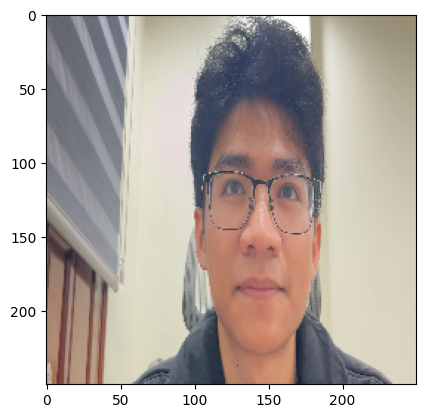

In [28]:
# Display the last captured frame (resized)
plt.imshow(cv2.cvtColor(frame_resized, cv2.COLOR_BGR2RGB))

# 2.x NEW - Data Augmentation


In [29]:
def data_aug(img):
    data = []
    for i in range(9):
        img = tf.image.stateless_random_brightness(img, max_delta=0.02, seed=(1, 2))
        img = tf.image.stateless_random_contrast(img, lower=0.6, upper=1, seed=(1, 3))
        # img = tf.image.stateless_random_crop(img, size=(20,20,3), seed=(1,2))
        img = tf.image.stateless_random_flip_left_right(
            img, seed=(np.random.randint(100), np.random.randint(100))
        )
        img = tf.image.stateless_random_jpeg_quality(
            img,
            min_jpeg_quality=90,
            max_jpeg_quality=100,
            seed=(np.random.randint(100), np.random.randint(100)),
        )
        img = tf.image.stateless_random_saturation(
            img,
            lower=0.9,
            upper=1,
            seed=(np.random.randint(100), np.random.randint(100)),
        )

        data.append(img)

    return data

In [30]:
import os
import uuid

In [ ]:
# Augment ALL anchor images
for file_name in os.listdir(ANC_PATH):
    img_path = os.path.join(ANC_PATH, file_name)
    img = cv2.imread(img_path)

    if img is None:
        print(f"Warning: Could not read {img_path}, skipping...")
        continue

    augmented_images = data_aug(img)

    for image in augmented_images:
        cv2.imwrite(
            os.path.join(ANC_PATH, "{}.jpg".format(uuid.uuid1())), image.numpy()
        )

print(f"Augmentation complete! Total anchor images: {len(os.listdir(ANC_PATH))}")

Augmentation complete! Total anchor images: 890


In [ ]:
# Augment ALL positive images
for file_name in os.listdir(POS_PATH):
    img_path = os.path.join(POS_PATH, file_name)
    img = cv2.imread(img_path)

    if img is None:
        print(f"Warning: Could not read {img_path}, skipping...")
        continue

    augmented_images = data_aug(img)

    for image in augmented_images:
        cv2.imwrite(
            os.path.join(POS_PATH, "{}.jpg".format(uuid.uuid1())), image.numpy()
        )

print(f"Augmentation complete! Total positive images: {len(os.listdir(POS_PATH))}")

# 3. Load and Preprocess Images


## 3.1 Get Image Directories


In [35]:
# Use os.path.join for cross-platform compatibility
anchor = tf.data.Dataset.list_files(os.path.join(ANC_PATH, "*.jpg")).take(3000)
positive = tf.data.Dataset.list_files(os.path.join(POS_PATH, "*.jpg")).take(3000)
negative = tf.data.Dataset.list_files(os.path.join(NEG_PATH, "*.jpg")).take(3000)

print(f"Anchor images: {len(list(anchor.as_numpy_iterator()))}")
print(f"Positive images: {len(list(positive.as_numpy_iterator()))}")
print(f"Negative images: {len(list(negative.as_numpy_iterator()))}")

Anchor images: 890
Positive images: 87
Negative images: 3000


2025-12-29 22:41:49.009909: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-12-29 22:41:49.017555: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-12-29 22:41:49.128954: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [36]:
dir_test = anchor.as_numpy_iterator()

In [37]:
print(dir_test.next())

b'data/anchor/b6ed2eb6-e4cc-11f0-8e04-4ef801895957.jpg'


## 3.2 Preprocessing - Scale and Resize


In [38]:
def preprocess(file_path):

    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image
    img = tf.io.decode_jpeg(byte_img)

    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100, 100))
    # Scale image to be between 0 and 1
    img = img / 255.0

    # Return image
    return img

In [39]:
# Test preprocess with an actual image from anchor folder
anchor_files = os.listdir(ANC_PATH)
if anchor_files:
    test_img_path = os.path.join(ANC_PATH, anchor_files[0])
    img = preprocess(test_img_path)
    print(f"Loaded image shape: {img.shape}")
else:
    print("No anchor images found!")

Loaded image shape: (100, 100, 3)


In [40]:
img.numpy().max()

1.0

## 3.3 Create Labelled Dataset


In [179]:
# (anchor, positive) => 1,1,1,1,1
# (anchor, negative) => 0,0,0,0,0

In [42]:
positives = tf.data.Dataset.zip(
    (anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor))))
)
negatives = tf.data.Dataset.zip(
    (anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor))))
)
data = positives.concatenate(negatives)

In [43]:
samples = data.as_numpy_iterator()

In [44]:
exampple = samples.next()

In [45]:
exampple

(b'data/anchor/b6ff371e-e4cc-11f0-8e04-4ef801895957.jpg',
 b'data/positive/270997bc-e4cc-11f0-8e04-4ef801895957.jpg',
 1.0)

## 3.4 Build Train and Test Partition


In [46]:
def preprocess_twin(input_img, validation_img, label):
    return (preprocess(input_img), preprocess(validation_img), label)

In [47]:
res = preprocess_twin(*exampple)

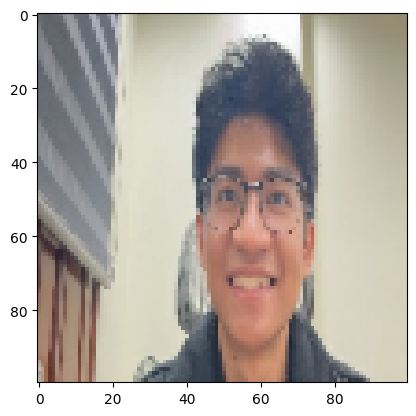

In [48]:
plt.imshow(res[1])

In [49]:
res[2]

1.0

In [50]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=10000)

In [51]:
# Training partition
train_data = data.take(round(len(data) * 0.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [52]:
# Testing partition
test_data = data.skip(round(len(data) * 0.7))
test_data = test_data.take(round(len(data) * 0.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

# 4. Model Engineering


## 4.1 Build Embedding Layer


In [53]:
inp = Input(shape=(100, 100, 3), name="input_image")

In [55]:
c1 = Conv2D(64, (10, 10), activation="relu")(inp)

In [56]:
m1 = MaxPooling2D(64, (2, 2), padding="same")(c1)

In [57]:
c2 = Conv2D(128, (7, 7), activation="relu")(m1)
m2 = MaxPooling2D(64, (2, 2), padding="same")(c2)

In [58]:
c3 = Conv2D(128, (4, 4), activation="relu")(m2)
m3 = MaxPooling2D(64, (2, 2), padding="same")(c3)

In [59]:
c4 = Conv2D(256, (4, 4), activation="relu")(m3)
f1 = Flatten()(c4)
d1 = Dense(4096, activation="sigmoid")(f1)

In [60]:
mod = Model(inputs=[inp], outputs=[d1], name="embedding")

In [61]:
mod.summary()

Model: "embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 91, 91, 64)     │        19,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 46, 46, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 40, 40, 128)    │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 17, 17, 128)    │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 6, 6, 256)      │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │    37,752,832 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

In [62]:
def make_embedding():
    inp = Input(shape=(100, 100, 3), name="input_image")

    # First block
    c1 = Conv2D(64, (10, 10), activation="relu")(inp)
    m1 = MaxPooling2D(64, (2, 2), padding="same")(c1)

    # Second block
    c2 = Conv2D(128, (7, 7), activation="relu")(m1)
    m2 = MaxPooling2D(64, (2, 2), padding="same")(c2)

    # Third block
    c3 = Conv2D(128, (4, 4), activation="relu")(m2)
    m3 = MaxPooling2D(64, (2, 2), padding="same")(c3)

    # Final embedding block
    c4 = Conv2D(256, (4, 4), activation="relu")(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation="sigmoid")(f1)

    return Model(inputs=[inp], outputs=[d1], name="embedding")

In [63]:
embedding = make_embedding()

In [64]:
embedding.summary()

Model: "embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 91, 91, 64)     │        19,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 46, 46, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 40, 40, 128)    │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 17, 17, 128)    │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 6, 6, 256)      │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4096)           │    37,752,832 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

## 4.2 Build Distance Layer


In [88]:
# Siamese L1 Distance class
class L1Dist(Layer):

    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    # Magic happens here - similarity calculation
    def call(self, input_embedding, validation_embedding):
        # Handle case where inputs might be wrapped in lists
        if isinstance(input_embedding, list):
            input_embedding = input_embedding[0]
        if isinstance(validation_embedding, list):
            validation_embedding = validation_embedding[0]
        return tf.math.abs(input_embedding - validation_embedding)

In [89]:
l1 = L1Dist()

## 4.3 Make Siamese Model


In [90]:
input_image = Input(name="input_img", shape=(100, 100, 3))
validation_image = Input(name="validation_img", shape=(100, 100, 3))

In [91]:
inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)

In [92]:
siamese_layer = L1Dist()

In [93]:
distances = siamese_layer(inp_embedding, val_embedding)

In [94]:
classifier = Dense(1, activation="sigmoid")(distances)

In [95]:
classifier

<KerasTensor shape=(None, 1), dtype=float32, sparse=False, ragged=False, name=keras_tensor_28>

In [96]:
siamese_network = Model(
    inputs=[input_image, validation_image], outputs=classifier, name="SiameseNetwork"
)

In [97]:
siamese_network.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img           │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ validation_img      │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 4096)      │ 38,960,448 │ input_img[0][0],  │
│ (Functional)        │                   │            │ validation_img[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l1_dist_7 (L1Dist)  │ (None, 4096)      │          0 │ embedding[6][0],  │
│                     │                   │            │ embedding[7][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │      4,097 │ l1_dist_7[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

In [98]:
def make_siamese_model():

    # Anchor image input in the network
    input_image = Input(name="input_img", shape=(100, 100, 3))

    # Validation image in the network
    validation_image = Input(name="validation_img", shape=(100, 100, 3))

    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = "distance"
    distances = siamese_layer(embedding(input_image), embedding(validation_image))

    # Classification layer
    classifier = Dense(1, activation="sigmoid")(distances)

    return Model(
        inputs=[input_image, validation_image],
        outputs=classifier,
        name="SiameseNetwork",
    )

In [99]:
siamese_model = make_siamese_model()

In [100]:
siamese_model.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img           │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ validation_img      │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 4096)      │ 38,960,448 │ input_img[0][0],  │
│ (Functional)        │                   │            │ validation_img[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l1_dist_8 (L1Dist)  │ (None, 4096)      │          0 │ embedding[8][0],  │
│                     │                   │            │ embedding[9][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │      4,097 │ l1_dist_8[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

# 5. Training


## 5.1 Setup Loss and Optimizer


In [101]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [102]:
opt = tf.keras.optimizers.Adam(1e-4)  # 0.0001

## 5.2 Establish Checkpoints


In [103]:
checkpoint_dir = "./training_checkpoints"
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

## 5.3 Build Train Step Function


In [104]:
test_batch = train_data.as_numpy_iterator()

In [105]:
batch_1 = test_batch.next()

In [106]:
X = batch_1[:2]

In [107]:
y = batch_1[2]

In [108]:
y

array([1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

In [109]:
tf.losses.BinaryCrossentropy

keras.src.losses.losses.BinaryCrossentropy

In [110]:
@tf.function
def train_step(batch):

    # Record all of our operations
    with tf.GradientTape() as tape:
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]

        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)

    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)

    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))

    # Return loss
    return loss

## 5.4 Build Training Loop


In [111]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

In [112]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS + 1):
        print("\n Epoch {}/{}".format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))

        # Creating a metric object
        r = Recall()
        p = Precision()

        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            loss = train_step(batch)
            yhat = siamese_model.predict(batch[:2])
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat)
            progbar.update(idx + 1)
        print(loss.numpy(), r.result().numpy(), p.result().numpy())

        # Save checkpoints
        if epoch % 10 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

## 5.5 Train the model


In [113]:
EPOCHS = 50

In [114]:
train(train_data, EPOCHS)


 Epoch 1/50
Tensor("binary_crossentropy/div_no_nan:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/div_no_nan:0", shape=(), dtype=float32)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 957ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 863ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 843ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 853ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 962ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 931ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 955ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 985ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/s

2025-12-29 22:57:45.917345: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/ste

2025-12-29 23:02:23.307709: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/ste

2025-12-29 23:07:14.152568: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/ste

2025-12-29 23:11:47.324334: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/ste

2025-12-29 23:16:36.350776: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/ste

2025-12-29 23:21:38.873515: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/ste

KeyboardInterrupt: 

# 6. Evaluate Model


## 6.1 Import Metrics


In [228]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

## 6.2 Make Predictions


In [229]:
# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [230]:
y_hat = siamese_model.predict([test_input, test_val])

In [ ]:
# Post processing the results
[1 if prediction > 0.5 else 0 for prediction in y_hat]

[1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1]

In [232]:
y_true

array([1., 1., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1.],
      dtype=float32)

## 6.3 Calculate Metrics


In [ ]:
# Creating a metric object
m = Recall()

# Calculating the recall value
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [ ]:
# Creating a metric object
m = Precision()

# Calculating the recall value
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [ ]:
r = Recall()
p = Precision()

for test_input, test_val, y_true in test_data.as_numpy_iterator():
    yhat = siamese_model.predict([test_input, test_val])
    r.update_state(y_true, yhat)
    p.update_state(y_true, yhat)

print(r.result().numpy(), p.result().numpy())

1.0 0.99889135


## 6.4 Viz Results


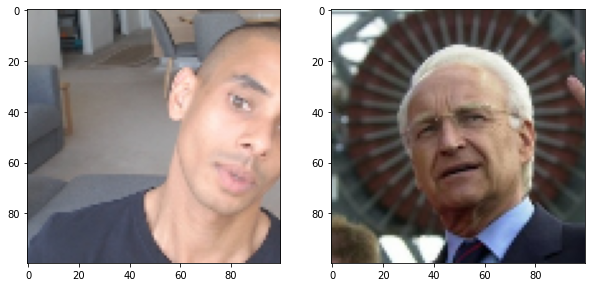

In [ ]:
# Set plot size
plt.figure(figsize=(10, 8))

# Set first subplot
plt.subplot(1, 2, 1)
plt.imshow(test_input[0])

# Set second subplot
plt.subplot(1, 2, 2)
plt.imshow(test_val[0])

# Renders cleanly
plt.show()

# 7. Save Model


In [ ]:
# Save weights
siamese_model.save("siamesemodelv2.h5")

In [ ]:
L1Dist

In [ ]:
# Reload model
siamese_model = tf.keras.models.load_model(
    "siamesemodelv2.h5",
    custom_objects={
        "L1Dist": L1Dist,
        "BinaryCrossentropy": tf.losses.BinaryCrossentropy,
    },
)

In [239]:
# Make predictions with reloaded model
siamese_model.predict([test_input, test_val])

array([[2.7295970e-05],
       [8.7373185e-01],
       [1.1476276e-06],
       [9.9997568e-01],
       [9.9490523e-01],
       [2.8164588e-06],
       [2.9260066e-06],
       [1.0000000e+00]], dtype=float32)

In [240]:
# View model summary
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_img (InputLayer)          [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
validation_img (InputLayer)     [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
embedding (Functional)          (None, 4096)         38960448    input_img[0][0]                  
                                                                 validation_img[0][0]             
__________________________________________________________________________________________________
l1_dist_6 (L1Dist)              (None, 4096)         0           embedding[0][0]     

# 8. Real Time Test


## 8.1 Verification Function


In [ ]:
application_data\verification_images

In [ ]:
os.listdir(os.path.join("application_data", "verification_images"))

In [ ]:
os.path.join("application_data", "input_image", "input_image.jpg")

In [ ]:
for image in os.listdir(os.path.join("application_data", "verification_images")):
    validation_img = os.path.join("application_data", "verification_images", image)
    print(validation_img)

In [ ]:
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(os.path.join("application_data", "verification_images")):
        input_img = preprocess(
            os.path.join("application_data", "input_image", "input_image.jpg")
        )
        validation_img = preprocess(
            os.path.join("application_data", "verification_images", image)
        )

        # Make Predictions
        result = model.predict(
            list(np.expand_dims([input_img, validation_img], axis=1))
        )
        results.append(result)

    # Detection Threshold: Metric above which a prediciton is considered positive
    detection = np.sum(np.array(results) > detection_threshold)

    # Verification Threshold: Proportion of positive predictions / total positive samples
    verification = detection / len(
        os.listdir(os.path.join("application_data", "verification_images"))
    )
    verified = verification > verification_threshold

    return results, verified

## 8.2 OpenCV Real Time Verification


In [ ]:
CAMERA_INDEX = 0  # Change to 1 for iPhone/external camera

cap = cv2.VideoCapture(CAMERA_INDEX)
while cap.isOpened():
    ret, frame = cap.read()

    if not ret:
        print("Failed to grab frame")
        break

    # Resize full frame to 250x250
    frame_resized = cv2.resize(frame, (250, 250))

    cv2.imshow("Verification", frame_resized)

    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord("v"):
        cv2.imwrite(
            os.path.join("application_data", "input_image", "input_image.jpg"),
            frame_resized,
        )
        # Run verification
        results, verified = verify(siamese_model, 0.5, 0.5)
        print(f"Verified: {verified}")

    if cv2.waitKey(10) & 0xFF == ord("q"):
        break

cap.release()
cv2.destroyAllWindows()

True


In [17]:
np.sum(np.squeeze(results) > 0.9)

36

In [18]:
results

[array([[0.9944859]], dtype=float32),
 array([[0.9999912]], dtype=float32),
 array([[0.9999943]], dtype=float32),
 array([[0.9999951]], dtype=float32),
 array([[0.99993753]], dtype=float32),
 array([[0.9082498]], dtype=float32),
 array([[0.9999846]], dtype=float32),
 array([[0.9834683]], dtype=float32),
 array([[0.87159216]], dtype=float32),
 array([[0.7328309]], dtype=float32),
 array([[0.74533516]], dtype=float32),
 array([[0.949607]], dtype=float32),
 array([[0.7501703]], dtype=float32),
 array([[0.60669833]], dtype=float32),
 array([[0.93921214]], dtype=float32),
 array([[0.9813106]], dtype=float32),
 array([[0.9848625]], dtype=float32),
 array([[0.89696234]], dtype=float32),
 array([[0.98896575]], dtype=float32),
 array([[0.99082947]], dtype=float32),
 array([[0.7747197]], dtype=float32),
 array([[0.99999297]], dtype=float32),
 array([[0.99986887]], dtype=float32),
 array([[0.9999764]], dtype=float32),
 array([[0.90808266]], dtype=float32),
 array([[0.8795649]], dtype=float32),
 a